# preprocessing achilles

In [209]:
from __future__ import print_function
import pandas as pd
import numpy as np
import sys

sys.path.insert(0, '..')

from src.CCLE_postp_function import *
from JKBio import terra
from JKBio.utils import helper as h
from JKBio.google import gcp
from gsheets import Sheets
from taigapy import TaigaClient
import dalmatian as dm
from JKBio.google.google_sheet import dfToSheet

from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import pearsonr,spearmanr

from bokeh.plotting import *
from bokeh.models import HoverTool
from collections import OrderedDict
from IPython.display import Image,display
from matplotlib import pyplot as plt
import seaborn as sns

%load_ext autoreload
%autoreload 2
%load_ext rpy2.ipython
tc = TaigaClient()
output_notebook()

my_id = '~/.client_secret.json'
mystorage_id = "~/.storage.json"
# do the first steps of https://medium.com/craftsmenltd/from-csv-to-google-sheet-using-python-ef097cb014f9
creds = '../.credentials.json'

sheets = Sheets.from_files(my_id, mystorage_id)
replace = {'T': 'Tumor', 'N': 'Normal', 'm': 'Unknown', 'L': 'Unknown'}

refsheet_url = "https://docs.google.com/spreadsheets/d/1Pgb5fIClGnErEqzxpU7qqX6ULpGTDjvzWwDN8XUJKIY"

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


Loading BokehJS ...

## boot up

we are instanciating all the parameters needed for this pipeline to run

In [174]:
samplesetname = "21Q1"
release=samplesetname

## Do some checks and manual rescuing

In [540]:
ccle_refsamples = sheets.get(refsheet_url).sheets[0].to_frame(index_col=0)

KeyboardInterrupt: 

In [ ]:
legacy_segments = tc.get(name='depmap-wes-cn-data--08f3', file='legacy_segments')
legacy_segments = legacy_segments.drop(columns='Unnamed: 0')
legacy_segments['Status']='U'

prevgenecn = (2**tc.get(name='depmap-a0ab', file='CCLE_gene_cn'))-1 
prevsegments = tc.get(name='depmap-a0ab', file='CCLE_segment_cn')
prevgenecn = (2**tc.get(name='internal-20q3-00d0', file='CCLE_gene_cn'))-1 
prev = prevgenecn.index.tolist()

In [541]:
priosegments = pd.read_csv("temp/segments_allWES_latest_"+samplesetname+".csv")
#priogenecn = pd.read_csv('temp/gene_cn_allWES_latest_'+samplesetname+".csv", index_col=0)

In [542]:
cyto = pd.read_csv('data/hg38_cytoband.gz', sep='\t',names=['chrom', 'start', 'end','loc','stains'])
cyto['chrom'] = [i[3:] for i in cyto['chrom']]
gene_mapping = pd.read_csv('data/genemapping_19Q1.csv')
onlyinleg = set(legacy_segments.DepMap_ID) - set(priosegments.DepMap_ID)
samegenes = set(prevgenecn.columns) & set(priogenecn.columns)
onlyinleg

{'ACH-000003',
 'ACH-000014',
 'ACH-000016',
 'ACH-000034',
 'ACH-000044',
 'ACH-000049',
 'ACH-000057',
 'ACH-000064',
 'ACH-000068',
 'ACH-000071',
 'ACH-000088',
 'ACH-000164',
 'ACH-000170',
 'ACH-000179',
 'ACH-000185',
 'ACH-000194',
 'ACH-000195',
 'ACH-000216',
 'ACH-000229',
 'ACH-000230',
 'ACH-000299',
 'ACH-000300',
 'ACH-000306',
 'ACH-000333',
 'ACH-000413',
 'ACH-000454',
 'ACH-000479',
 'ACH-000494',
 'ACH-000526',
 'ACH-000539',
 'ACH-000550',
 'ACH-000575',
 'ACH-000578',
 'ACH-000600',
 'ACH-000612',
 'ACH-000632',
 'ACH-000635',
 'ACH-000642',
 'ACH-000659',
 'ACH-000690',
 'ACH-000705',
 'ACH-000710',
 'ACH-000731',
 'ACH-000737',
 'ACH-000739',
 'ACH-000742',
 'ACH-000842',
 'ACH-000850',
 'ACH-000854',
 'ACH-000870',
 'ACH-000901',
 'ACH-000904',
 'ACH-000923',
 'ACH-000928',
 'ACH-000931',
 'ACH-000982',
 'ACH-001000',
 'ACH-001015',
 'ACH-001017',
 'ACH-001018',
 'ACH-001036',
 'ACH-001037',
 'ACH-001042',
 'ACH-001043',
 'ACH-001044',
 'ACH-001045',
 'ACH-0010

In [518]:
bad = ["ACH-001011",
"ACH-001108",
"ACH-001187",
"ACH-001189",
"ACH-002303",
"ACH-002315",
"ACH-002341"]

In [543]:
onlyinleng.append("ACH-002291")

NameError: name 'onlyinleng' is not defined

In [519]:
for val in onlyinleg:
    print(val,legacy_segments[legacy_segments.DepMap_ID==val].Source.values[0])

ACH-000578 Broad SNP
ACH-001000 Broad SNP
ACH-001071 Broad SNP
ACH-000742 Broad SNP
ACH-000737 Broad SNP
ACH-001230 Broad SNP
ACH-002378 Sanger WES
ACH-001171 Broad SNP
ACH-000195 Broad SNP
ACH-000982 Broad SNP
ACH-001225 Broad SNP
ACH-000710 Broad SNP
ACH-000635 Broad SNP
ACH-001088 Broad SNP
ACH-001214 Broad SNP
ACH-000690 Broad SNP
ACH-000454 Broad SNP
ACH-000739 Broad SNP
ACH-001146 Broad SNP
ACH-001188 Broad SNP
ACH-000931 Broad SNP
ACH-001198 Broad SNP
ACH-000333 Broad SNP
ACH-000494 Broad SNP
ACH-000044 Broad SNP
ACH-000179 Broad SNP
ACH-001092 Broad SNP
ACH-000413 Broad SNP
ACH-001224 Broad SNP
ACH-000034 Broad SNP
ACH-001239 Broad SNP
ACH-001015 Broad SNP
ACH-001087 Broad SNP
ACH-000928 Broad SNP
ACH-000923 Broad SNP
ACH-000642 Broad SNP
ACH-000850 Broad SNP
ACH-000550 Broad SNP
ACH-001044 Broad SNP
ACH-001036 Broad SNP
ACH-000901 Broad SNP
ACH-000300 Broad SNP
ACH-000612 Broad SNP
ACH-000216 Broad SNP
ACH-001045 Broad SNP
ACH-000064 Broad SNP
ACH-001249 Broad SNP
ACH-001130 B

In [218]:
priogenecn.shape

(1694, 27562)

In [ ]:
## only gettinng good correlation samples

## Achilles repriorization

In [247]:
corr = {}
ge = np.log2(1+priogenecn[samegenes])
pre = np.log2(1+prevgenecn[samegenes]).fillna(0)
for sample in set(prevgenecn.index) & set(priogenecn.index):
        corr[sample] = pearsonr(ge.loc[sample],pre.loc[sample])[0]   
toreplace = []
for k, val in corr.items():
    if val<0.85:
        toreplace.append(k)
len(toreplace)/len(corr)

<AxesSubplot:>

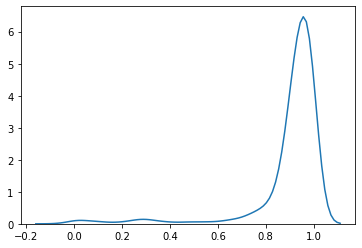

In [257]:
a = np.array(list(corr.values()))
sns.kdeplot(a)

<AxesSubplot:>

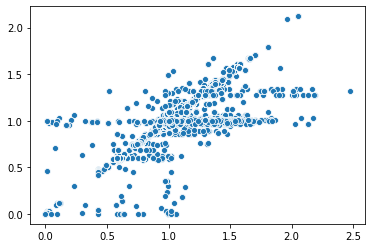

In [260]:
ind = set(prevgenecn.index) & set(priogenecn.index)
sns.scatterplot(x=ge.loc[ind].values.ravel()[:100000],y=pre.loc[ind].values.ravel()[:100000],)

/home/jeremie/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:679: UserWarning: Passing a 2D dataset for a bivariate plot is deprecated in favor of kdeplot(x, y), and it will cause an error in future versions. Please update your code.
  warnings.warn(warn_msg, UserWarning)
/home/jeremie/miniconda3/lib/python3.7/site-packages/seaborn/distributions.py:423: UserWarning: The following kwargs were not used by contour: 'fill'
  cset = contour_func(xx, yy, z, n_levels, **kwargs)


<AxesSubplot:>

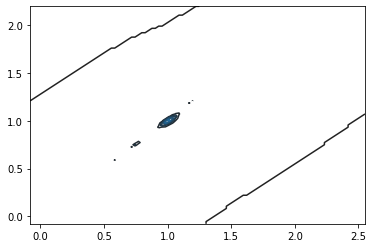

In [261]:
sns.kdeplot(data=np.array([ge.loc[ind].values.ravel()[:100000], pre.loc[ind].values.ravel()[:100000]]).T, fill=True)

In [520]:
#mergedsegments = priosegments[~priosegments.DepMap_ID.isin(toreplace)].append(legacy_segments[legacy_segments.DepMap_ID.isin(toreplace)]).reset_index(drop=True)
mergedsegments = priosegments

In [521]:
mergedsegments = mergedsegments.append(legacy_segments[legacy_segments.DepMap_ID.isin(list(onlyinleg))]).reset_index(drop=True)

### Adding WGS

In [522]:
wgssegments = pd.read_csv("temp/segments_allWGS_latest_"+samplesetname+".csv")
#wgssegments = pd.read_csv("temp/segments_allWGS_latest_"+samplesetname+".csv")
wgssegments.Segment_Mean.max()

1064.007791437255

In [523]:
mergedsegments = wgssegments.append(mergedsegments[~mergedsegments.DepMap_ID.isin(set(wgssegments.DepMap_ID))])

In [278]:
lost = set(["ACH-002217",
"ACH-002335",
"ACH-002378"])

In [280]:
#only in snp
onlyinleg - ( lost | set(wgssegments.DepMap_ID))

{'ACH-000003',
 'ACH-000016',
 'ACH-000034',
 'ACH-000049',
 'ACH-000057',
 'ACH-000064',
 'ACH-000071',
 'ACH-000088',
 'ACH-000170',
 'ACH-000185',
 'ACH-000194',
 'ACH-000216',
 'ACH-000229',
 'ACH-000230',
 'ACH-000299',
 'ACH-000300',
 'ACH-000306',
 'ACH-000333',
 'ACH-000413',
 'ACH-000494',
 'ACH-000526',
 'ACH-000539',
 'ACH-000575',
 'ACH-000578',
 'ACH-000600',
 'ACH-000612',
 'ACH-000642',
 'ACH-000690',
 'ACH-000710',
 'ACH-000731',
 'ACH-000737',
 'ACH-000742',
 'ACH-000850',
 'ACH-000854',
 'ACH-000901',
 'ACH-000904',
 'ACH-000923',
 'ACH-000931',
 'ACH-001000',
 'ACH-001015',
 'ACH-001017',
 'ACH-001018',
 'ACH-001036',
 'ACH-001037',
 'ACH-001042',
 'ACH-001043',
 'ACH-001044',
 'ACH-001045',
 'ACH-001047',
 'ACH-001071',
 'ACH-001072',
 'ACH-001079',
 'ACH-001087',
 'ACH-001088',
 'ACH-001091',
 'ACH-001092',
 'ACH-001094',
 'ACH-001101',
 'ACH-001121',
 'ACH-001130',
 'ACH-001142',
 'ACH-001146',
 'ACH-001150',
 'ACH-001171',
 'ACH-001175',
 'ACH-001188',
 'ACH-0011

### removing normal lines

In [460]:
normals = ccle_refsamples[ccle_refsamples['primary_disease']=='normal'].index.tolist()
normals

['CDS-qoxhbS',
 'CDS-8qS051',
 'CDS-N4XOP4',
 'CDS-dHm43o',
 'CDS-RY8Xzr',
 'CDS-aW2WNp',
 'CDS-i3CvRQ',
 'CDS-ceYrXN',
 'CDS-Vn4Lqz',
 'CDS-ZTuykY',
 'CDS-uFRsR5',
 'CDS-2lPWAu',
 'CDS-BqISJN',
 'CDS-Lp8aNF',
 'CDS-y8dyN3',
 'CDS-9lQ9IO',
 'CDS-GV3cEP',
 'CDS-WzlUq5',
 'CDS-j35TQu',
 'CDS-G9UTIP',
 'CDS-FBHw9R',
 'CDS-kDfBIJ',
 'CDS-sfEmV7',
 'CDS-NDqt5o',
 'CDS-r5BVpP',
 'CDS-hE31oD',
 'CDS-5hu4Rw',
 'CDS-RHgkeR',
 'CDS-K73lpj',
 'CDS-Q290gd',
 'CDS-XyNs73',
 'CDS-kJmvfG',
 'CDS-61xvH5',
 'CDS-OFsvdk',
 'CDS-R1Hs0F',
 'CDS-WNQqt7',
 'CDS-eGC7tM',
 'CDS-qwRpXW',
 'CDS-398s6n',
 'CDS-k4KpaH',
 'CDS-Qyy8pU',
 'CDS-yall0D',
 'CDS-F7KLHU',
 'CDS-gPsFVQ',
 'CDS-iJ7qQb',
 'CDS-nP8UEl',
 'CDS-GEdSsY',
 'CDS-JyD6h6',
 'CDS-m5nf8o',
 'CDS-mGa4QW',
 'CDS-yA6vRq',
 'CDS-LRlcFN',
 'CDS-nEN3Tc',
 'CDS-KWISke',
 'CDS-thfoJD',
 'CDS-7ordve',
 'CDS-Dv6oUS',
 'CDS-HJ4BWj',
 'CDS-eXIgmH',
 'CDS-J5JBNV',
 'CDS-2X1ZaF',
 'CDS-rycIQo',
 'CDS-BlealE',
 'CDS-OPZGq1',
 'CDS-9wfYSe',
 'CDS-6dPoX7',
 'CDS-xgln

In [459]:
#mergedsegments = mergedsegments[~mergedsegments.DepMap_ID.isin(normals)]

### removing duplicate because engineered:


In [524]:
mergedsegments = mergedsegments[~mergedsegments.DepMap_ID.isin(["ACH-003000", "ACH-002875", "ACH-002874"])]

### adding duplicate lines for Achilles

In [336]:
#removing any possible instance of "chr"
#mergedsegments.Chromosome = [i[3:] if 'chr' in i else i for i in mergedsegments.Chromosome]
set(mergedsegments.Chromosome)

{'1',
 '10',
 '11',
 '12',
 '13',
 '14',
 '15',
 '16',
 '17',
 '18',
 '19',
 '2',
 '20',
 '21',
 '22',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 'X',
 'Y'}

In [525]:
mergedsegments = mergedsegments[['DepMap_ID', 'Chromosome', 'Start', 'End', 'Segment_Mean', 'Num_Probes', 'Status', 'Source']].sort_values(by=['DepMap_ID', 'Chromosome', 'Start', 'End']).reset_index(drop=True)
#setting amplification status to U for X chromosome as it is artificially amplified in female samples:
mergedsegments.loc[mergedsegments[mergedsegments.Chromosome=="X"].index,'Status'] = 'U'

In [526]:
mergedsegments = manageGapsInSegments(mergedsegments, cyto=cyto)
mergedgenecn = toGeneMatrix(mergedsegments, gene_mapping).apply(lambda x: np.log2(1+x))
set(mergedsegments.Source)

{'Broad SNP', 'Broad WES', 'Broad WGS', 'Chordoma WES', 'Sanger WES'}

In [528]:
a = set(mergedgenecn.index) & set(prevgenecn.index)
b = set(mergedgenecn.columns) & set(prevgenecn.columns)

In [ ]:
match, corr= findClosestMatching(mergedgenecn, prevgenecn, closest=True, returncorr=True)

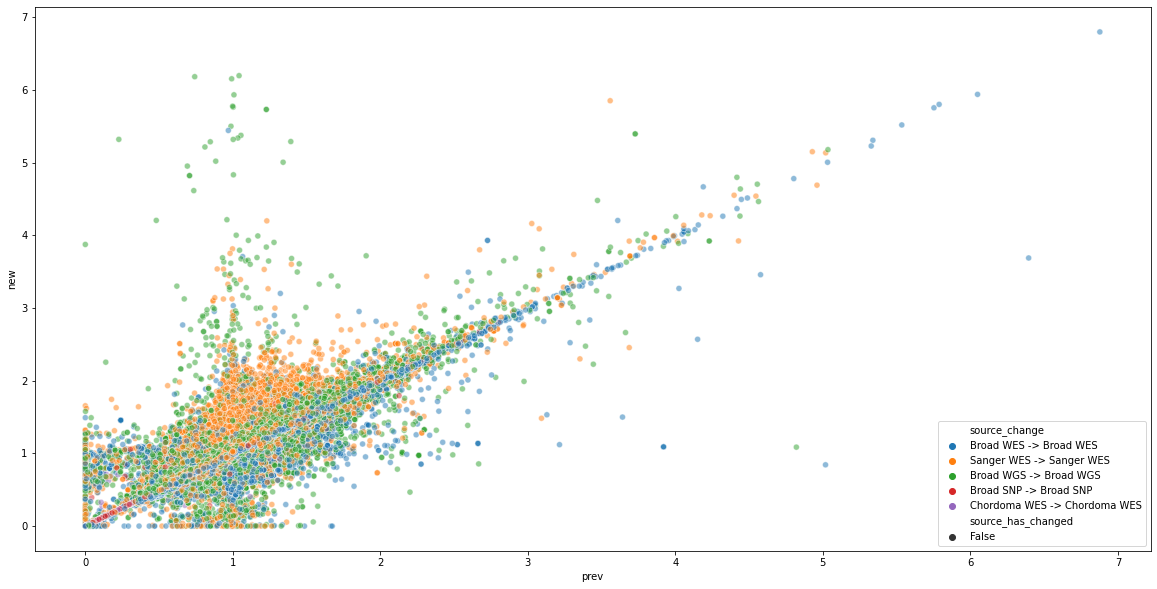

In [534]:
plotCNchanges(mergedgenecn, prevgenecn.apply(lambda x: np.log2(1+x)), mergedsegments, prevsegments)

In [530]:
if(mergedgenecn.values.max() > 100):
    print("\n\n\nTOO HIGH, not LOG2 transformed!")
if(len(mergedgenecn.index) > len(set(mergedgenecn.index))):
    print("Duplicate CL, not reprioritized well!")

In [454]:
mergedgenecn.isna().sum().sum()

177

In [373]:
rna = tc.get(name='depmap-a0ab', file='CCLE_expression_proteincoding_genes_expected_count')

1395 18498
0.18503289119573857 18498
1373 18635
0.18482174791491704 18635


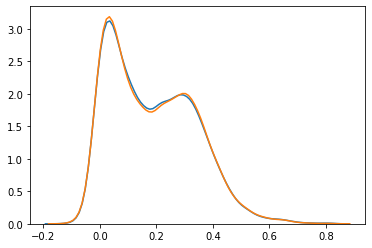

In [486]:
_, ax = plt.subplots()
rnaseqcorrelation(mergedgenecn.fillna(0), rna.fillna(0), ax, name="20Q4")
rnaseqcorrelation(prevgenecn[prevgenecn.index.isin(mergedgenecn.index.tolist())], rna.fillna(0), ax, name="20Q3")

In [533]:
h.compareDfs(mergedgenecn, tc.get(name='internal-20q2-7f46', version=18, file='CCLE_gene_cn'))

FOUND missmatch Columns IN df1: {'LOC101928322 (101928322)', 'LOC100288778 (100288778)', 'PRORY (100533178)', 'FAM213A (84293)', 'LINC01660 (729461)', 'DDX3Y (8653)', 'SEPT2 (4735)', 'FAM19A3 (284467)', 'FAM197Y5 (100289150)', 'C9orf41-AS1 (101927380)', 'TTTY13 (83868)', 'LOC100128242 (100128242)', 'LOC105378349 (105378349)', 'MGEA5 (10724)', 'FAM213B (127281)', 'NACAP1 (83955)', 'SSFA2 (6744)', 'TSPY4 (728395)', 'LOC101928226 (101928226)', 'C19orf66 (55337)', 'LOC105369192 (105369192)', 'LOC102724589 (102724589)', 'RAMMET (83640)', 'GAS6-AS2 (100506394)', 'FAM173B (134145)', 'TSPY8 (728403)', 'PAPD7 (11044)', 'DEC1 (50514)', 'DIGIT (108868751)', 'SSX6 (280657)', 'WHAMMP1 (100288615)', 'TTTY5 (83863)', 'MINOS1-NBL1 (100532736)', 'SEPT3 (55964)', 'LOC100996415 (100996415)', 'MKL2 (57496)', 'C19orf70 (125988)', 'LOC105373300 (105373300)', 'LOC102723780 (102723780)', 'ZFY-AS1 (107987337)', 'C3orf58 (205428)', 'LOC101926942 (101926942)', 'C1orf123 (54987)', 'METTL13 (51603)', 'WISP1 (8840)

({'AAED1 (195827)',
  'AES (166)',
  'ALPPL2 (251)',
  'ALS2CR12 (130540)',
  'AMELY (266)',
  'APOPT1 (84334)',
  'ARHGEF34P (728377)',
  'ATP5S (27109)',
  'AURKAPS1 (6791)',
  'BAGE5 (85316)',
  'BCORP1 (286554)',
  'BRE-AS1 (100302650)',
  'C10orf111 (221060)',
  'C11orf40 (143501)',
  'C14orf144 (145195)',
  'C15orf38-AP3S2 (100526783)',
  'C15orf53 (400359)',
  'C15orf59 (388135)',
  'C15orf59-AS1 (101929221)',
  'C16orf45 (89927)',
  'C17orf47 (284083)',
  'C17orf51 (339263)',
  'C19orf66 (55337)',
  'C19orf70 (125988)',
  'C1orf123 (54987)',
  'C20orf196 (149840)',
  'C21orf2 (755)',
  'C2orf40 (84417)',
  'C2orf54 (79919)',
  'C2orf71 (388939)',
  'C3orf30 (152405)',
  'C3orf58 (205428)',
  'C5orf60 (285679)',
  'C6orf10 (10665)',
  'C6orf106 (64771)',
  'C6orf48 (50854)',
  'C7orf13 (129790)',
  'C7orf43 (55262)',
  'C7orf55-LUC7L2 (100996928)',
  'C8orf46 (254778)',
  'C8orf59 (401466)',
  'C9orf3 (84909)',
  'C9orf41-AS1 (101927380)',
  'C9orf66 (157983)',
  'C9orf84 (15840

In [498]:
h.compareDfs(mergedgenecn, tc.get(name='depmap-a0ab', file='CCLE_gene_cn'))
#h.compareDfs(mergedsegments, tc.get(name='depmap-a0ab', file='CCLE_segment_cn'))

FOUND missmatch Columns IN df1: set()
FOUND missmatch Columns NOT IN df1: set()
FOUND missmatch Index IN df1: {'ACH-002822', 'ACH-001756', 'ACH-001813', 'ACH-002504', 'ACH-001760', 'ACH-001828', 'ACH-002828', 'ACH-001975', 'ACH-001953', 'ACH-002061', 'ACH-001046', 'ACH-002699', 'ACH-002047', 'ACH-001994', 'ACH-001985', 'ACH-001981', 'ACH-001978', 'ACH-002476', 'ACH-002034', 'ACH-001980', 'ACH-001701', 'ACH-001974', 'ACH-001700', 'ACH-001759', 'ACH-001992', 'ACH-001503', 'ACH-001227', 'ACH-002013', 'ACH-001683', 'ACH-001986', 'ACH-001984', 'ACH-001983', 'ACH-001705', 'ACH-001817', 'ACH-001982', 'ACH-002080', 'ACH-002851', 'ACH-002074', 'ACH-001447', 'ACH-001976', 'ACH-001492', 'ACH-002818', 'ACH-003210', 'ACH-002055', 'ACH-002810', 'ACH-001977', 'ACH-002084', 'ACH-001697', 'ACH-001571', 'ACH-001707', 'ACH-001691', 'ACH-002138', 'ACH-002060', 'ACH-001675', 'ACH-001758', 'ACH-002825', 'ACH-001434', 'ACH-001686', 'ACH-001949'}
FOUND missmatch Index NOT IN df1: set()
FOUND new NAs in df1: -

(set(),
 set(),
 {'ACH-001046',
  'ACH-001227',
  'ACH-001434',
  'ACH-001447',
  'ACH-001492',
  'ACH-001503',
  'ACH-001571',
  'ACH-001675',
  'ACH-001683',
  'ACH-001686',
  'ACH-001691',
  'ACH-001697',
  'ACH-001700',
  'ACH-001701',
  'ACH-001705',
  'ACH-001707',
  'ACH-001756',
  'ACH-001758',
  'ACH-001759',
  'ACH-001760',
  'ACH-001813',
  'ACH-001817',
  'ACH-001828',
  'ACH-001949',
  'ACH-001953',
  'ACH-001974',
  'ACH-001975',
  'ACH-001976',
  'ACH-001977',
  'ACH-001978',
  'ACH-001980',
  'ACH-001981',
  'ACH-001982',
  'ACH-001983',
  'ACH-001984',
  'ACH-001985',
  'ACH-001986',
  'ACH-001992',
  'ACH-001994',
  'ACH-002013',
  'ACH-002034',
  'ACH-002047',
  'ACH-002055',
  'ACH-002060',
  'ACH-002061',
  'ACH-002074',
  'ACH-002080',
  'ACH-002084',
  'ACH-002138',
  'ACH-002476',
  'ACH-002504',
  'ACH-002699',
  'ACH-002810',
  'ACH-002818',
  'ACH-002822',
  'ACH-002825',
  'ACH-002828',
  'ACH-002851',
  'ACH-003210'},
 set(),
 -382458,
 -2539848)

In [537]:
mergedgenecn.to_csv('temp/all_'+release+'_gene_cn.csv')
mergedsegments.to_csv('temp/all_'+release+'_segment.csv', index=False)

# uploading on taiga

## CN

In [538]:
tc.update_dataset(dataset_permaname="cn-wes-achilles-4dcd",
                 upload_file_path_dict={
            'temp/all_'+release+'_segment.csv': 'TableCSV',
            'temp/all_'+release+'_gene_cn.csv': "NumericMatrixCSV"}, 
                 changes_description="",
                  dataset_description="""
# Copy Number

Combined segment and gene-level CN calls from Broad WES, Sanger WES, and Broad SNP. Relative CN, log2(x+1) transformed.

PORTAL TEAM SHOULD NOT USE THIS: There are lines here that should not make it even to internal. Must use subsetted dataset instead. These data will not make it on the portal starting 19Q1. With the DMC portal, there is new cell line release prioritization as to which lines can be included, so a new taiga dataset will be created containing CN for the portal.

These data are generated for Achilles to pull from to run CERES.


Gene level CN data:

__Rows__: DepMap cell line IDs

__Columns__: gene names in the format HGNC\_symbol (Entrez\_ID)

Segment level data:

__Columns__: DepMap\_ID, Chromosome, Start, End, Num\_Probes, Segment\_Mean""")

Uploading all_21Q1_segment...
hitting https://cds.team/taiga/api/datafile/24fde70876da427b8893e836664eed93
Conversion and upload...:
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3
	 Uploading to S3

	 Done: all_21Q1_segment properly converted and uploaded
Uploading all_21Q1_gene_cn...
hitting https://cds.team/taiga/api/datafile/24fde70876da427b8893e836664eed93
Conversion and upload...:
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to determine size (line 1001)
	 Scanning through file to d

'dcb1b76ea9e74c4a810c3e86a1543388'